# Incidents notebook
The goal of this notebook is to estimate probability laws of incidents from FDS logs.

Let's import libraries and data :

In [88]:
from tqdm import tqdm

import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats as stats
import matplotlib.pyplot as plt
import utils

In [4]:
logs = utils.load_player_logs().dropna()
logs.Day = logs.Day.astype(int)
logs.Cycle = logs.Cycle.astype(int)
logs.Ship = logs.Ship.astype(int)
logs.Character = logs.Character.apply(lambda x: x.capitalize())

In [5]:
logs

,Ship,Character,Day.Cycle,Event,Log,Day,Cycle
0,1,Janice,2.4,NEW_CREW_MEMBER,*Janice* s'est éveillée de son si long sommeil.,2,4
1,1,Janice,2.4,CHARACTER_LEFT,*Janice* est sortie.,2,4
2,1,Janice,2.4,CHARACTER_ENTERED,*Janice* est entrée.,2,4
3,1,Janice,2.4,CUDDLE_OTHER,"*Janice* réconforte *Finola*, ça ira mieux de...",2,4
4,1,Janice,2.4,CHARACTER_LEFT,*Janice* est sortie.,2,4
...,...,...,...,...,...,...,...
8169400,1714,Raluca,17.1,MORAL_DOWN,Vous avez perdu 1 moral.,17,1
8169401,1714,Raluca,17.1,HP_UP,Vous avez gagné 1 hp.,17,1
8169402,1714,Raluca,17.2,LOG_ANXIETY_ATTACK,"Vous ressentez des frissons, l'espoir vous qu...",17,2
8169403,1714,Raluca,17.2,MORAL_DOWN,Vous avez perdu 3 moral.,17,2


## Reminders about game mechanics

There are 8 types of incidents in the game : metal plates, tremors, panic attacks, fires, electric discharges, equipment failures, door failures and spontaneous diseases.

Each cycle, the game draws a random number of each type of incident.

This draw depends of the day, the precedent draws (and their gestion by players) and the action points spent by the crew, among other factors.

We will make the following assumptions to simplify the problem :
- all types of incidents follows the same probability law
- this law depends only on the day

## Modelisation
As all events follows the same probability law, let's call $C_j$ the aleatory variable representing the number of incidents in a cycle for a fixed day $j$.

A natural law for $C_j$ is then the Poisson law with parameter $\lambda_j$, which represents the average number of incidents per cycle in day $j$.

We will note that there are 8 cycles per day. So we can define a new aleatory variable $D_j$ representing the number of incidents in a day $j$.

And $D_j = \sum_{i=1}^{8} C_{j,i}$. As $C_{j,i}$ follows the same Poisson law for each $i$ and are indepedents, we can write $D_j \sim \text{Poisson}(a_j)$ where $a_j = 8\lambda_j$.

We can then estimate $\lambda_j$ through $D_j$, which is easier to study.

(At the end, we can use a statistical test to check if the estimated law fit the observed data)

## Estimation

Population : Mush ships

Aleatory variable : $D_j$ the number of incidents in a ship for a fixed day $j$

Law : Poisson law with parameter $a_j$.

Sample : $(D_{j1}, ..., D_{jn})$ iid. of law $Poisson(a_j)$:
- size $n = \#numberOfShipsWhichReachedDayJ$ 
- empirical mean $\bar{d_j} = \frac{1}{n} \sum_{i=1}^n d_{ji}$ (where $d_{ji}$ is the realisation of $D_j$ for the $i$-th ship)
- empirical variance $\hat{s_j}^2 = \frac{1}{n} \sum_{i=1}^n (d_{ji} - \bar{d_j})^2$


The maximum likelihood estimator of $a_j$ is $\hat{a_j} = \bar{d_j}$.

Then, as $a_j = 8\lambda_j$, an estimator of $\lambda_j$ is $\hat{\lambda_j} = \frac{\hat{a_j}}{8}$.

We will use the number of metal plates as a proxy for the number of incidents (as we made the assumption that all types of incidents follows the same probability law).

Let's flag all logs with a metal plate incident :

In [6]:
logs["metal_plate"] = logs["Event"].apply(lambda x: 1 if x == "EV_ACCIDENT" else 0)

Then, for each day observed in the dataset, we will compute the estimators described above.

In [298]:
incidents = pd.DataFrame()

for day in tqdm(range(1, logs.Day.max() + 1)):
    day_incidents = logs[logs['Day'] == day].groupby("Ship").sum()["metal_plate"]
    n = len(day_incidents)
    
    d_j = (1/n) * np.sum(day_incidents)
    s_j_2 = (1/n) * np.sum((day_incidents - d_j)**2)
    if s_j_2 == 0:
        continue

    incidents = pd.concat([incidents, pd.DataFrame
        ({
        'j': day,
        'a_j': d_j,
        'var(a_j)': s_j_2 / n,
        'lambda_j': (1/8) * d_j,
        'var(lambda_j)': (1/64) * s_j_2 / n,
        'n': n
        }, index=[0])], ignore_index=True)

100%|██████████| 81/81 [00:02<00:00, 35.66it/s]


In [299]:
incidents

,j,a_j,var(a_j),lambda_j,var(lambda_j),n
0,1,0.002921,0.000002,0.000365,2.657739e-08,1712
1,2,0.236842,0.000149,0.029605,2.335542e-06,1710
2,3,0.405738,0.000248,0.050717,3.876833e-06,1708
3,4,0.253641,0.000158,0.031705,2.462222e-06,1648
4,5,0.330070,0.000251,0.041259,3.929035e-06,1430
...,...,...,...,...,...,...
66,67,30.500000,36.125000,3.812500,5.644531e-01,2
67,68,23.000000,4.500000,2.875000,7.031250e-02,2
68,69,29.000000,0.500000,3.625000,7.812500e-03,2
69,70,21.000000,18.000000,2.625000,2.812500e-01,2


/home/cytech/miniconda3/envs/fds_logs_analysis/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0, 0.5, 'Average incidents per cycle')

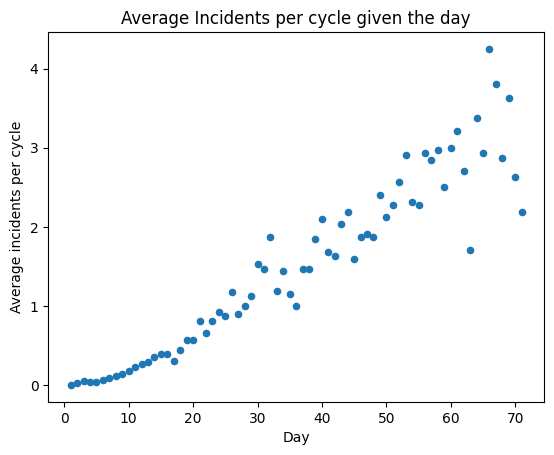

In [300]:
incidents.plot(x='j', y='lambda_j', kind='scatter')
plt.title("Average Incidents per cycle given the day")
plt.xlabel("Day")
plt.ylabel("Average incidents per cycle")

We can now use a naive regression to express the average number of incidents per cycle as a power function of the day :

In [257]:
def func(x, a, b):
    return a * np.power(x, b)

In [301]:
f, _ = opt.curve_fit(func, incidents['j'], incidents['lambda_j'], sigma = np.sqrt(incidents['var(lambda_j)']))
f

array([0.00333438, 1.65620137])

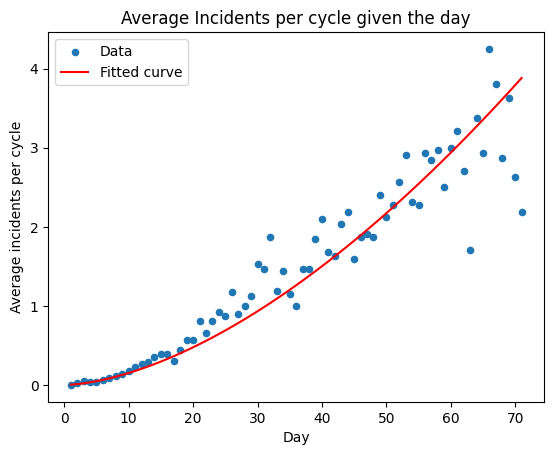

In [302]:
incidents.plot(x='j', y='lambda_j', kind='scatter')

j = incidents['j']
f_j = f[0] * np.power(j, f[1])

plt.plot(j, f_j, color='red')

plt.title("Average Incidents per cycle given the day")
plt.xlabel("Day")
plt.ylabel("Average incidents per cycle")
plt.legend(['Data', 'Fitted curve'])

We have $\lambda_{day} \simeq 3.3 \times 10^{-3} \times day^{1.7}$.

## Adequacy of the model with the data

We will use a Chi-square test to check if the estimated laws fit the observed data.

We will use the following hypothesis test :
- $H_0$ : $D_j \sim Poisson(8 * \lambda_j)$  with $\lambda_{day} \simeq 3.3 \times 10^{-3} \times day^{1.7}$
- $H_1$ : $D_j \sim Poisson(8 * \lambda_j)$ is not verified

If the p-value is lower than 0.05, we will reject $H_0$.

In [203]:
# hack to get chi2 test to work : 
# https://stackoverflow.com/questions/73168987/chi-squared-analysis-on-data-sets-that-dont-have-matching-frequencies
def hacked_chisquare(actual_data, predicted_data):
    return stats.chisquare(actual_data, np.sum(actual_data)/np.sum(predicted_data) * predicted_data)

  0%|          | 0/71 [00:00<?, ?it/s]

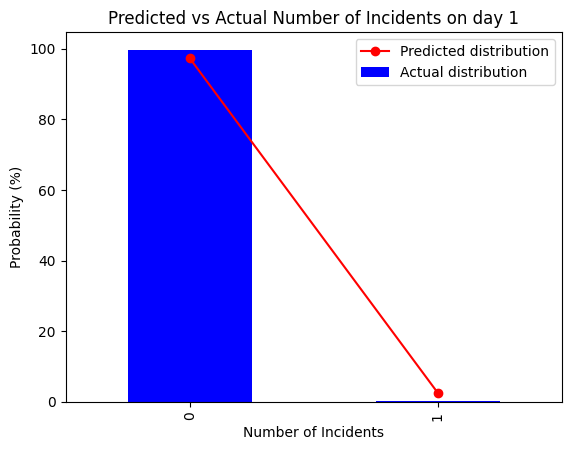

  1%|▏         | 1/71 [00:00<00:20,  3.36it/s]

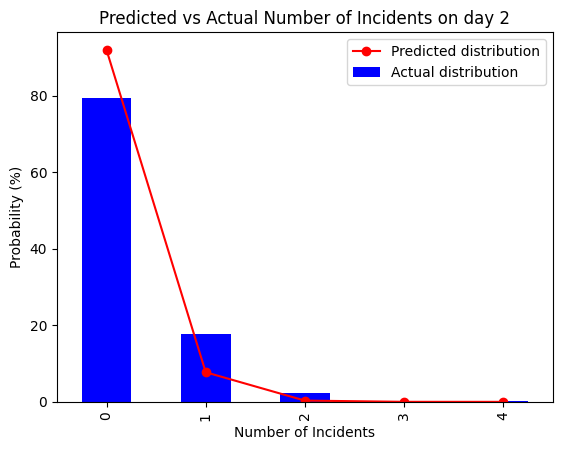

  3%|▎         | 2/71 [00:00<00:24,  2.82it/s]

Day 2 is not Poisson distributed with p-value 1.270663025013675e-21


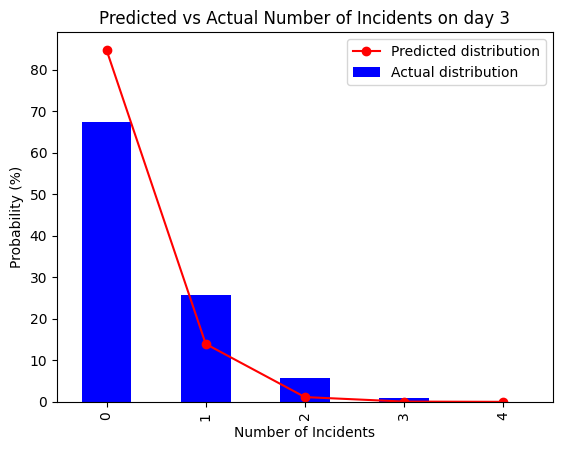

  4%|▍         | 3/71 [00:01<00:23,  2.93it/s]

Day 3 is not Poisson distributed with p-value 1.2720738057801796e-09


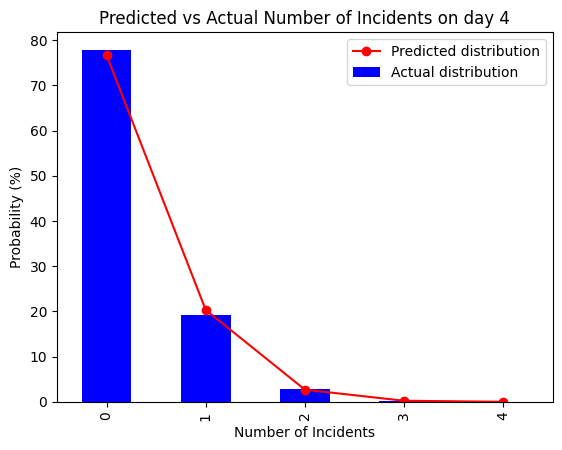

  6%|▌         | 4/71 [00:01<00:22,  2.99it/s]

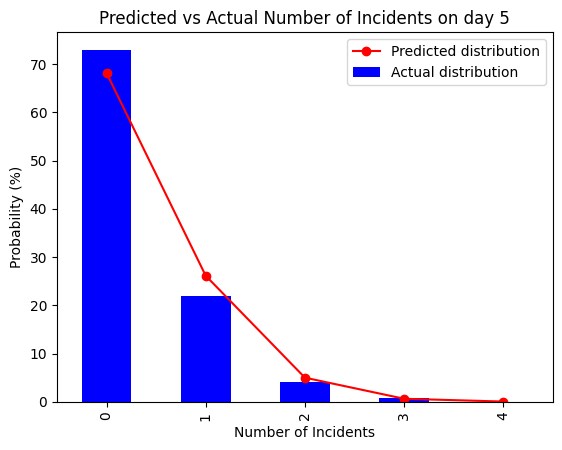

  7%|▋         | 5/71 [00:01<00:20,  3.22it/s]

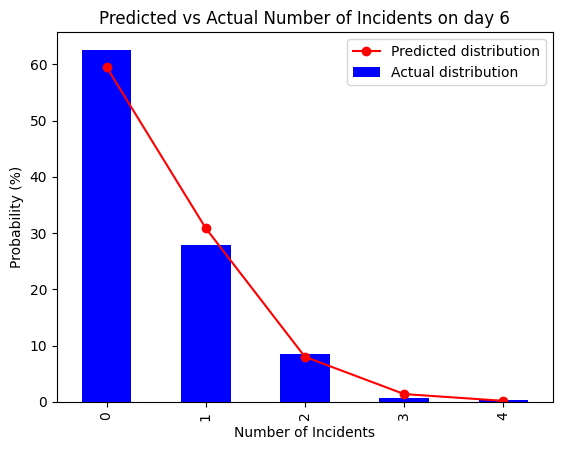

  8%|▊         | 6/71 [00:01<00:18,  3.55it/s]

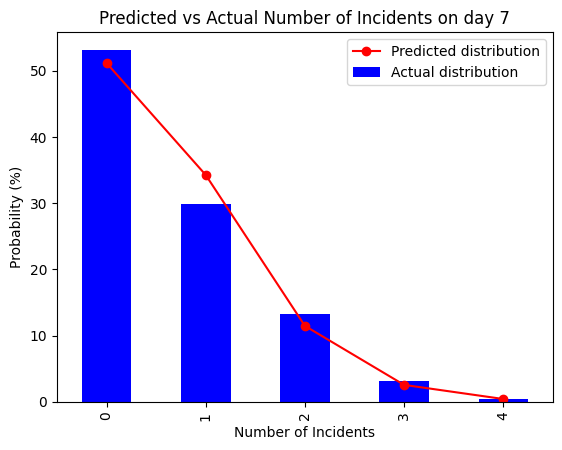

 10%|▉         | 7/71 [00:02<00:16,  3.91it/s]

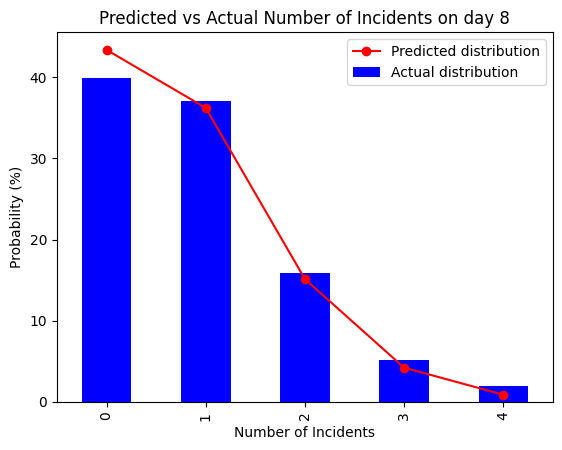

 11%|█▏        | 8/71 [00:02<00:14,  4.27it/s]

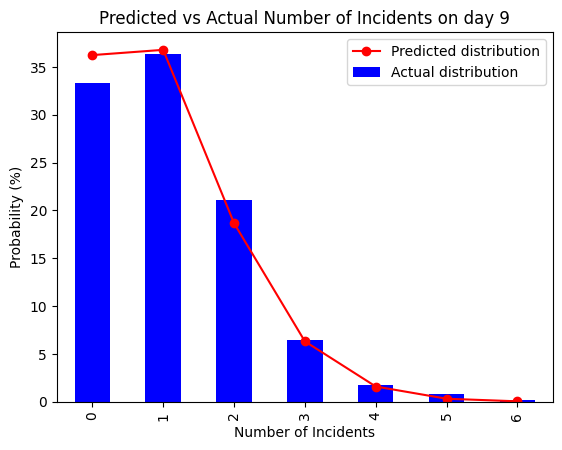

 13%|█▎        | 9/71 [00:02<00:14,  4.33it/s]

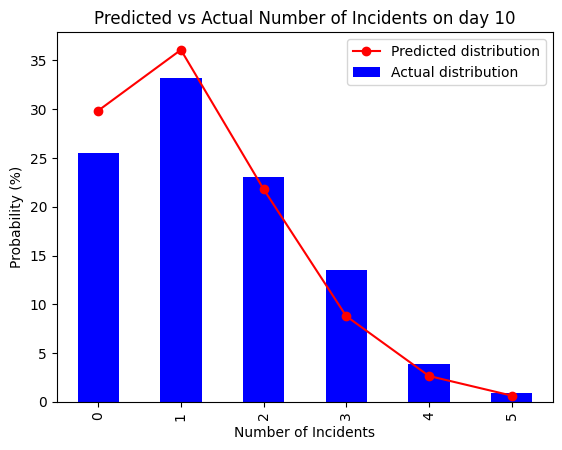

 14%|█▍        | 10/71 [00:02<00:13,  4.48it/s]

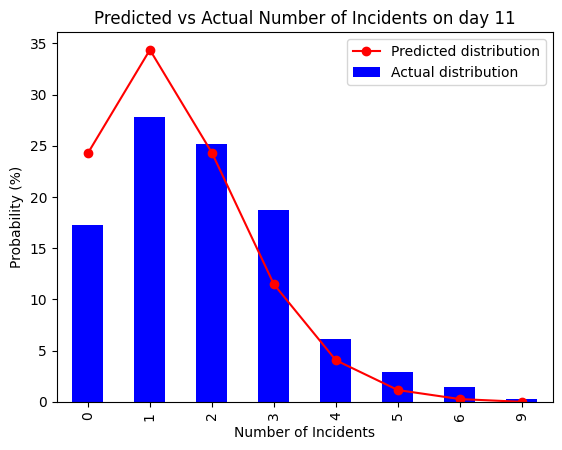

 15%|█▌        | 11/71 [00:02<00:12,  4.66it/s]

Day 11 is not Poisson distributed with p-value 4.0388300737462597e-13


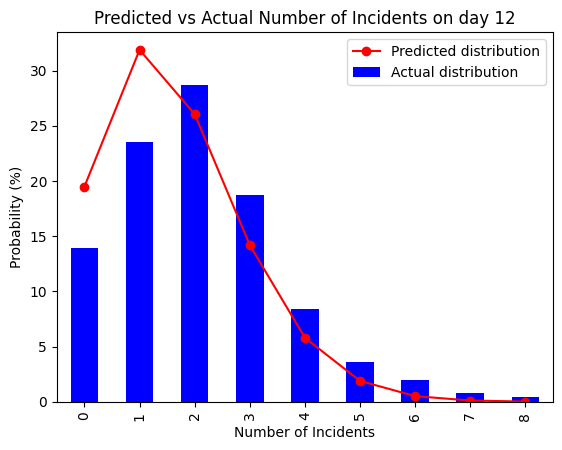

 17%|█▋        | 12/71 [00:03<00:12,  4.68it/s]

Day 12 is not Poisson distributed with p-value 0.005330279417647938


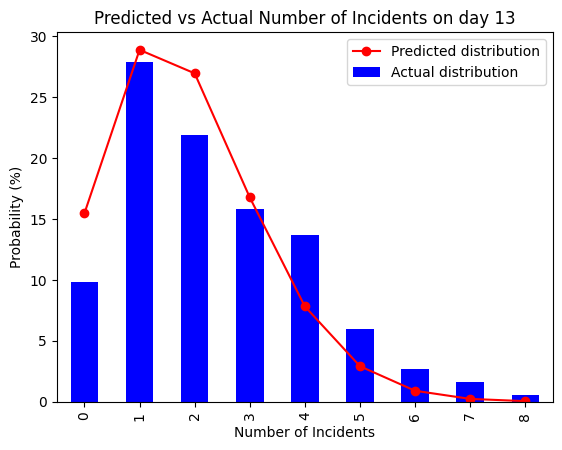

 18%|█▊        | 13/71 [00:03<00:11,  4.88it/s]

Day 13 is not Poisson distributed with p-value 0.0007974996524660068


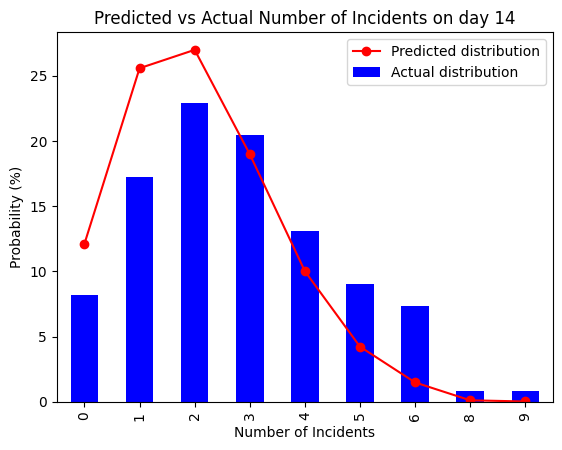

Day 14 is not Poisson distributed with p-value 3.0017749197367267e-10


 20%|█▉        | 14/71 [00:03<00:11,  4.90it/s]

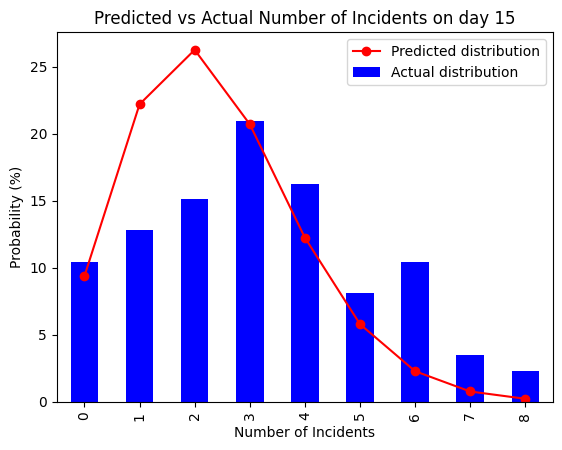

 21%|██        | 15/71 [00:03<00:10,  5.12it/s]

Day 15 is not Poisson distributed with p-value 7.234233148514836e-12


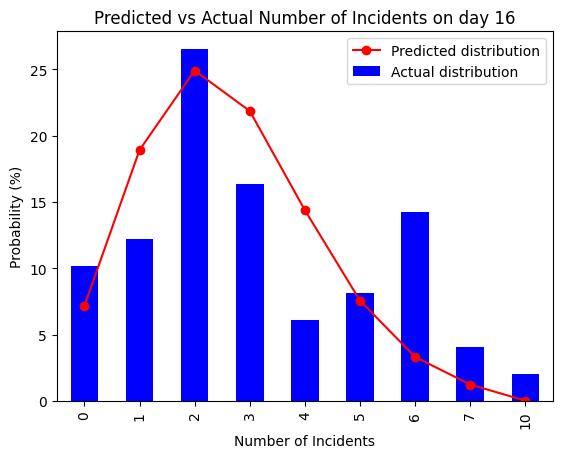

 23%|██▎       | 16/71 [00:03<00:10,  5.28it/s]

Day 16 is not Poisson distributed with p-value 1.689311118338528e-34


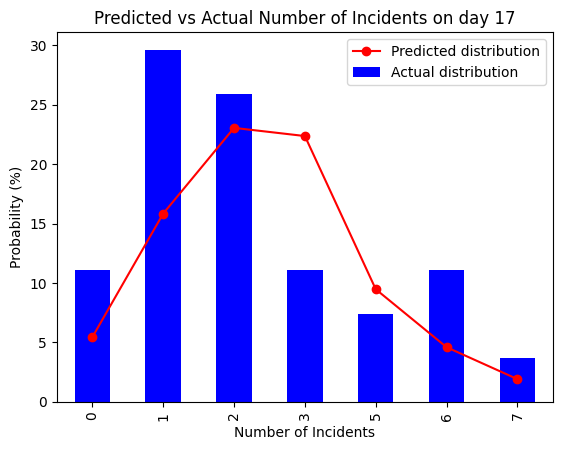

 24%|██▍       | 17/71 [00:03<00:09,  5.42it/s]

Day 17 is not Poisson distributed with p-value 0.00020552636691677128


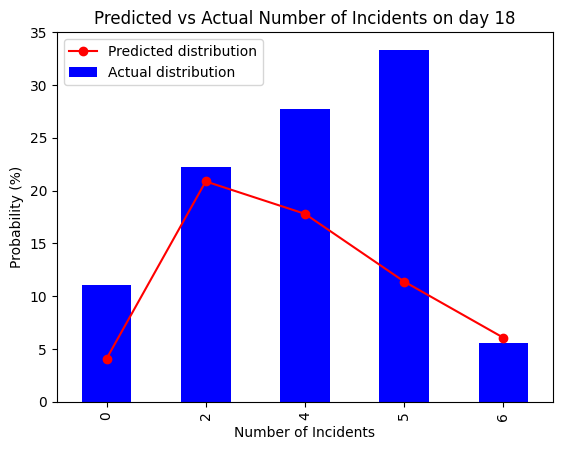

 25%|██▌       | 18/71 [00:04<00:09,  5.66it/s]

Day 18 is not Poisson distributed with p-value 0.00042190150907500456


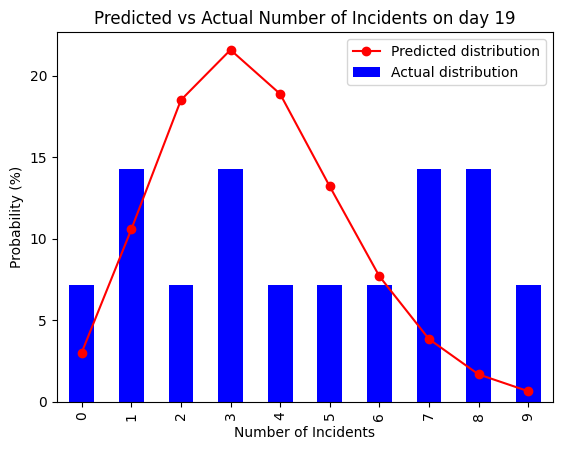

 27%|██▋       | 19/71 [00:04<00:09,  5.69it/s]

Day 19 is not Poisson distributed with p-value 7.814899013720548e-41


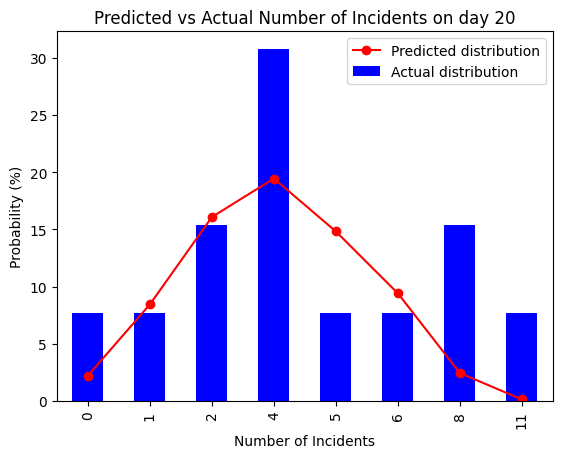

 28%|██▊       | 20/71 [00:04<00:10,  4.88it/s]

Day 20 is not Poisson distributed with p-value 3.7438864354110735e-75


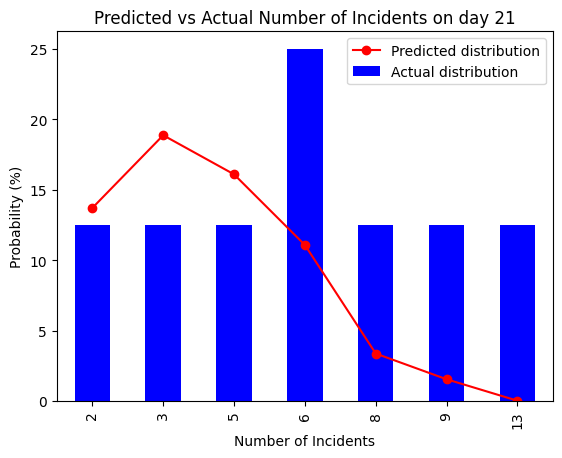

 30%|██▉       | 21/71 [00:04<00:09,  5.26it/s]

Day 21 is not Poisson distributed with p-value 0.0


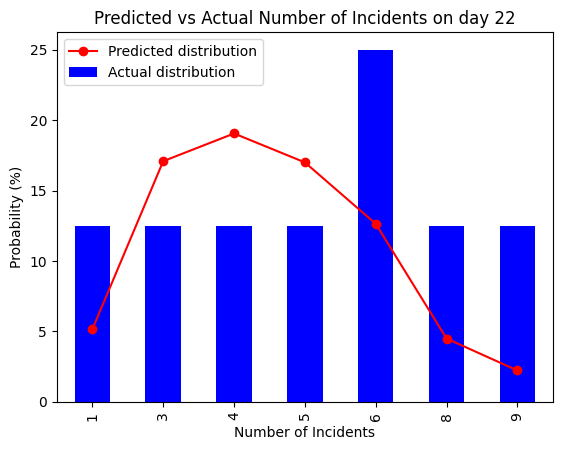

 31%|███       | 22/71 [00:04<00:09,  5.36it/s]

Day 22 is not Poisson distributed with p-value 6.7023768167746514e-12


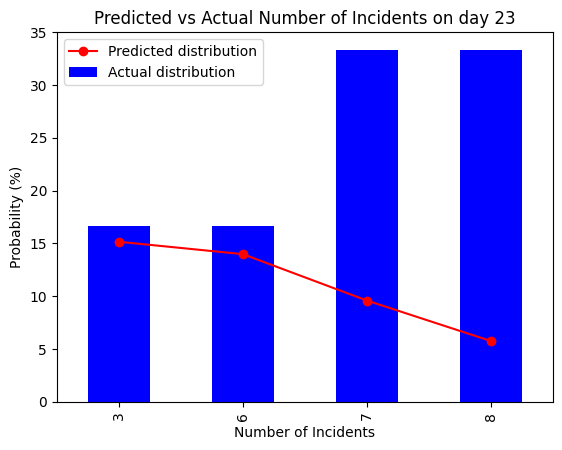

 32%|███▏      | 23/71 [00:05<00:08,  5.36it/s]

Day 23 is not Poisson distributed with p-value 9.288856451992334e-12


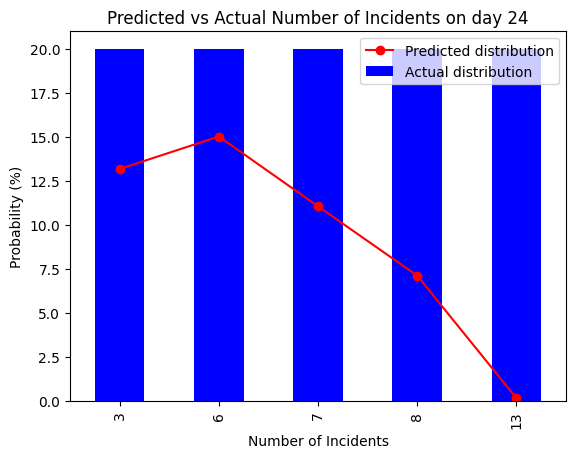

 34%|███▍      | 24/71 [00:05<00:08,  5.50it/s]

Day 24 is not Poisson distributed with p-value 8.010438021385021e-233


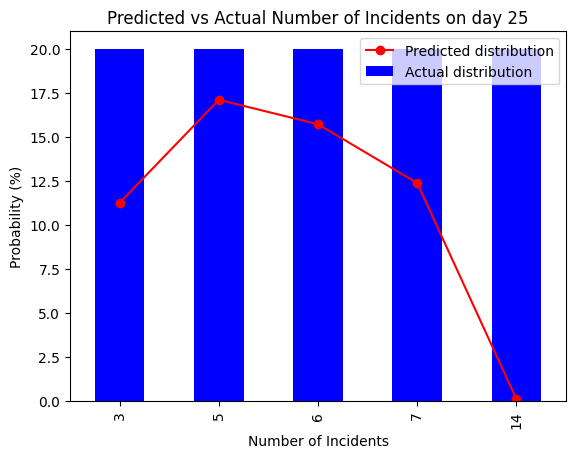

 35%|███▌      | 25/71 [00:05<00:08,  5.41it/s]

Day 25 is not Poisson distributed with p-value 0.0


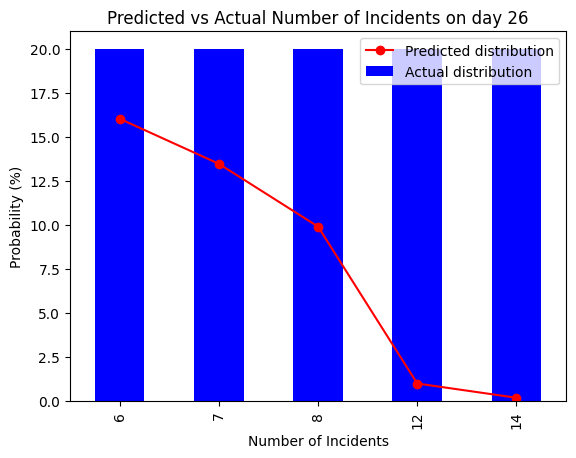

 37%|███▋      | 26/71 [00:05<00:08,  5.41it/s]

Day 26 is not Poisson distributed with p-value 1.0820746306967774e-205


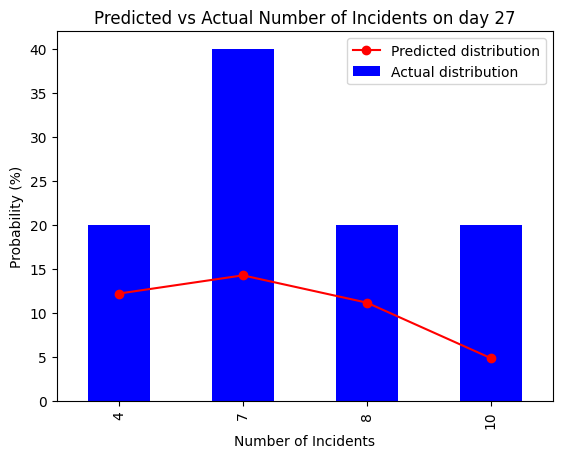

 38%|███▊      | 27/71 [00:05<00:08,  5.45it/s]

Day 27 is not Poisson distributed with p-value 0.008265803550977743


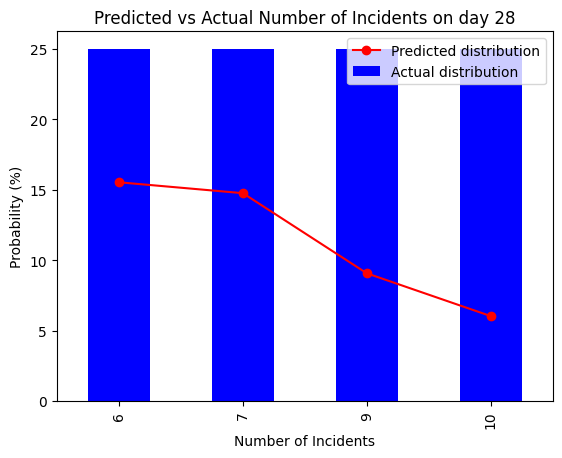

 39%|███▉      | 28/71 [00:05<00:07,  5.72it/s]

Day 28 is not Poisson distributed with p-value 0.0012402534027250633


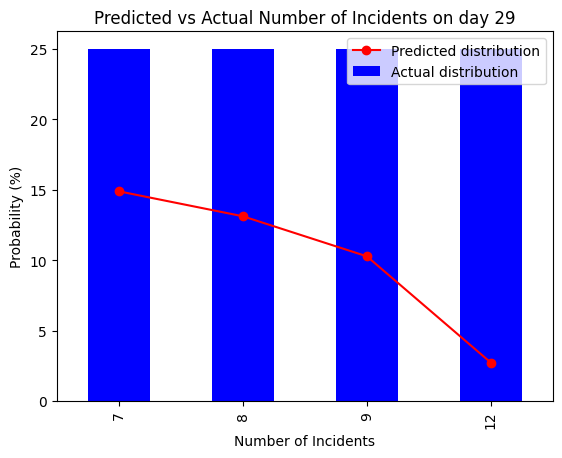

 41%|████      | 29/71 [00:06<00:07,  5.76it/s]

Day 29 is not Poisson distributed with p-value 4.8612593283772515e-12


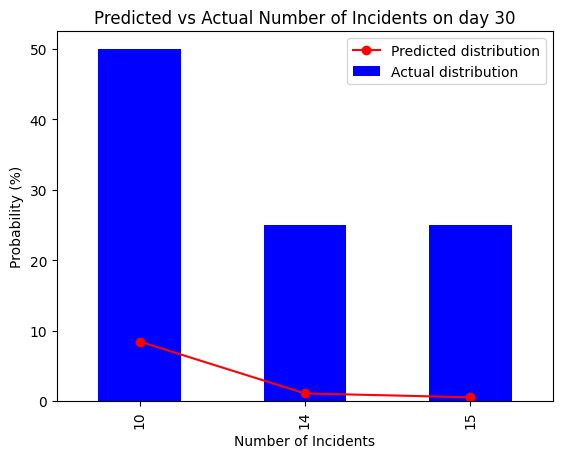

 42%|████▏     | 30/71 [00:06<00:07,  5.15it/s]

Day 30 is not Poisson distributed with p-value 2.237383130956296e-23


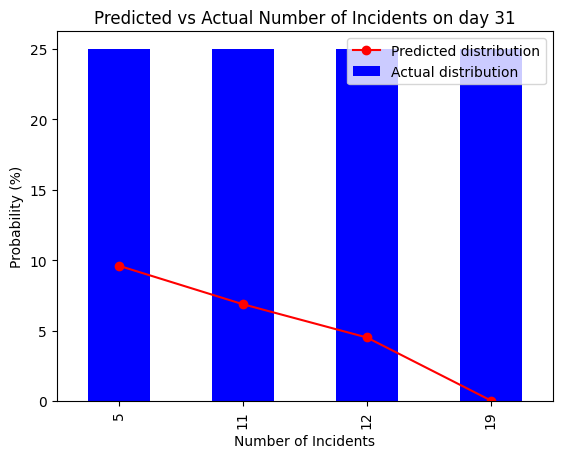

 44%|████▎     | 31/71 [00:06<00:07,  5.33it/s]

Day 31 is not Poisson distributed with p-value 0.0


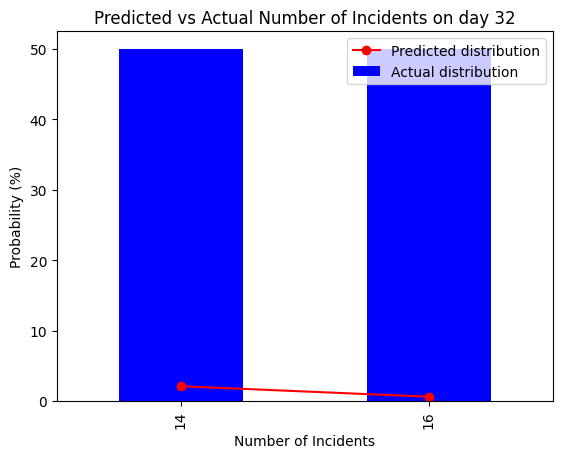

 45%|████▌     | 32/71 [00:06<00:06,  5.75it/s]

Day 32 is not Poisson distributed with p-value 2.783644823408017e-11


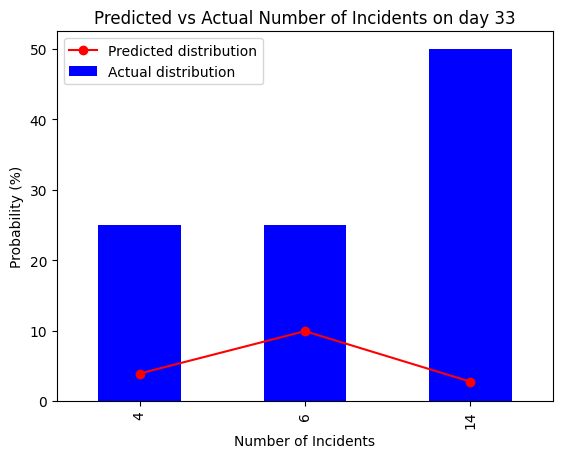

 46%|████▋     | 33/71 [00:06<00:06,  5.99it/s]

Day 33 is not Poisson distributed with p-value 1.337257883453416e-19


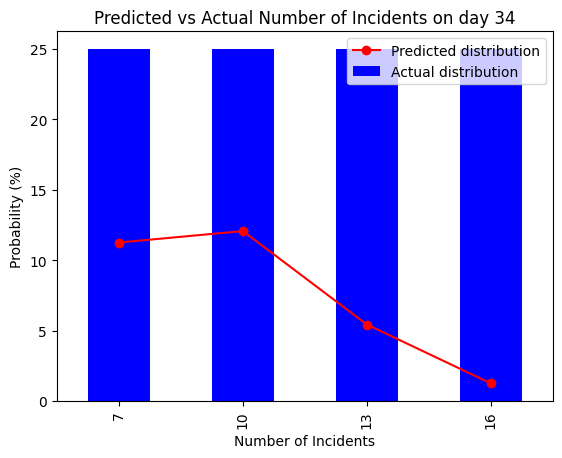

 48%|████▊     | 34/71 [00:07<00:06,  5.67it/s]

Day 34 is not Poisson distributed with p-value 3.363718274761408e-25


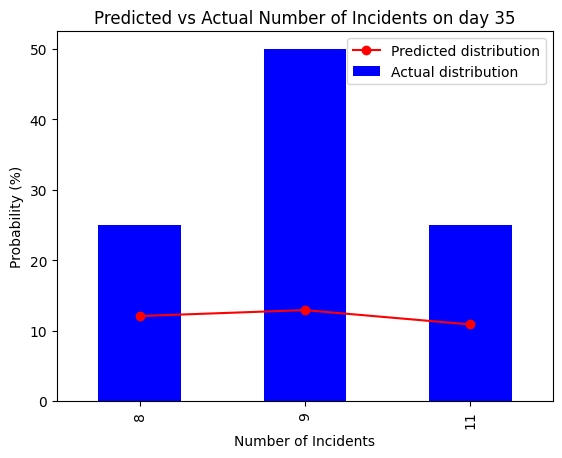

 49%|████▉     | 35/71 [00:07<00:06,  5.40it/s]

Day 35 is not Poisson distributed with p-value 0.01353581682397016


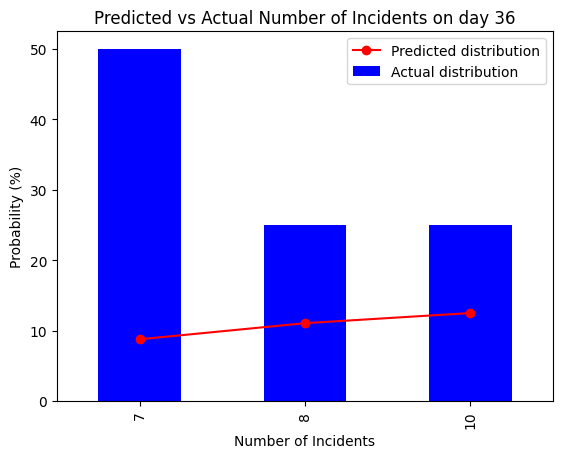

 51%|█████     | 36/71 [00:07<00:06,  5.60it/s]

Day 36 is not Poisson distributed with p-value 1.7051755944505597e-06


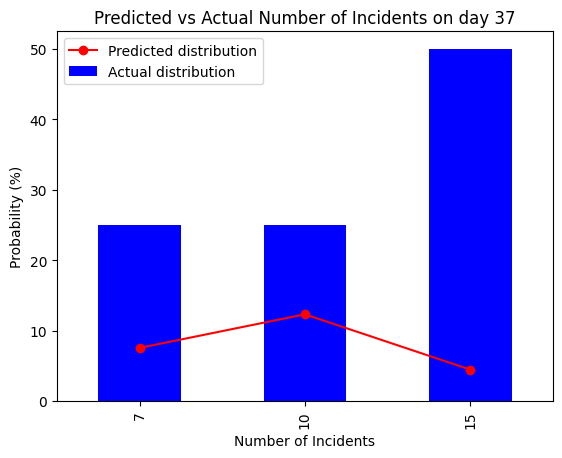

 52%|█████▏    | 37/71 [00:07<00:05,  5.68it/s]

Day 37 is not Poisson distributed with p-value 1.3168441535404826e-15


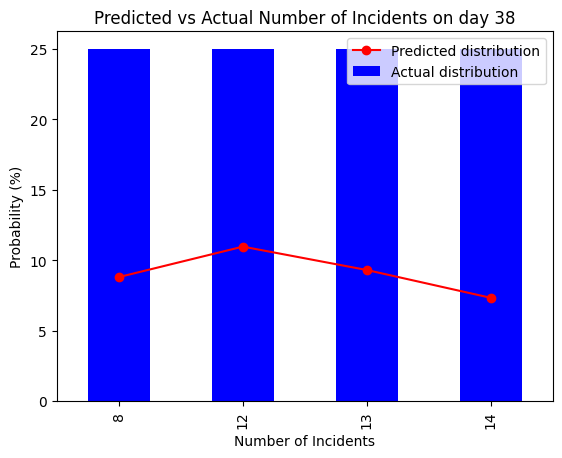

 54%|█████▎    | 38/71 [00:07<00:05,  5.53it/s]

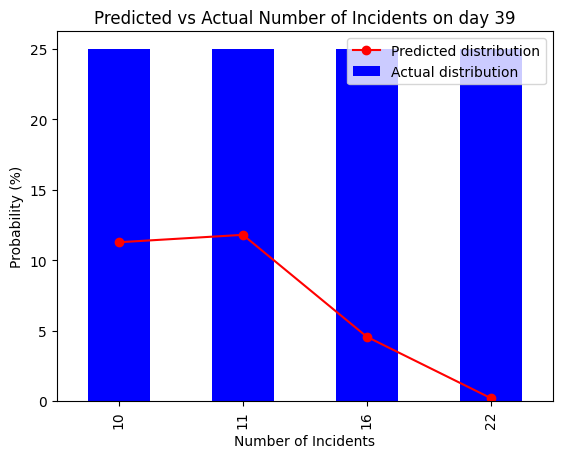

 55%|█████▍    | 39/71 [00:07<00:05,  5.50it/s]

Day 39 is not Poisson distributed with p-value 1.32243131976865e-183


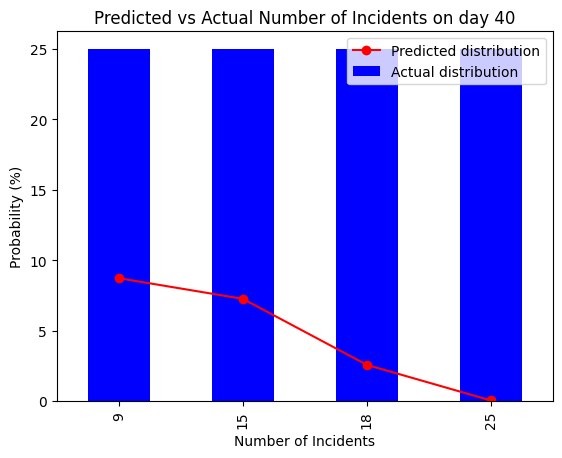

 56%|█████▋    | 40/71 [00:08<00:06,  5.08it/s]

Day 40 is not Poisson distributed with p-value 0.0


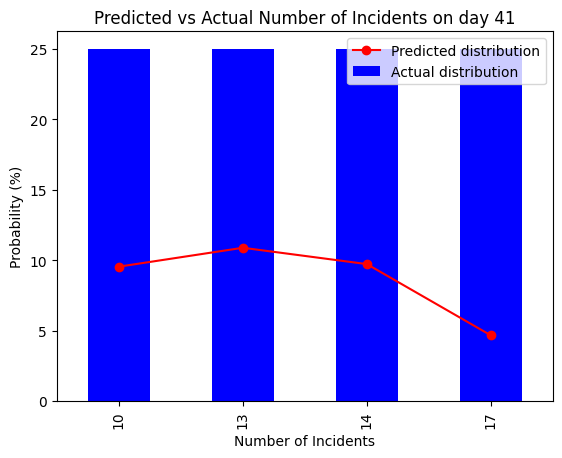

 58%|█████▊    | 41/71 [00:08<00:05,  5.22it/s]

Day 41 is not Poisson distributed with p-value 0.008018713079301824


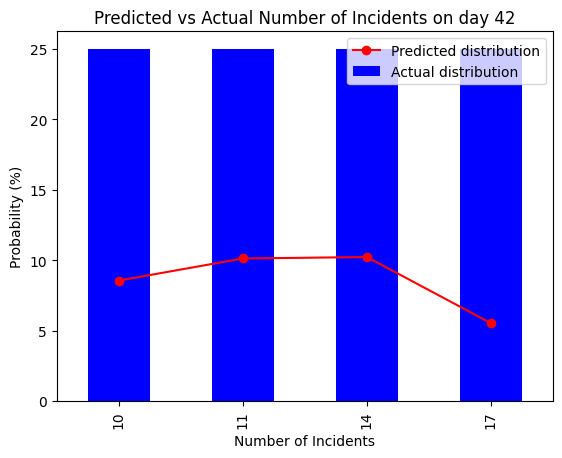

 59%|█████▉    | 42/71 [00:08<00:05,  5.35it/s]

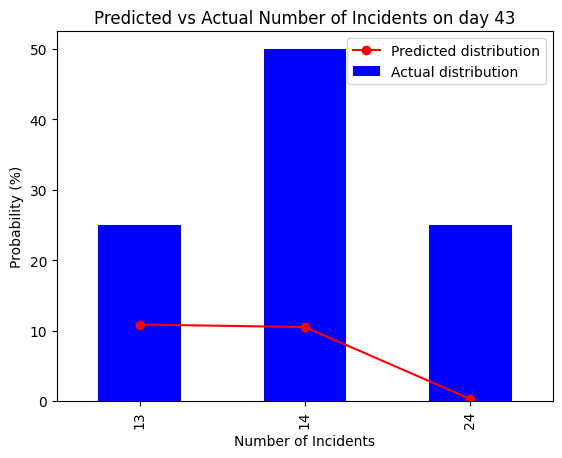

 61%|██████    | 43/71 [00:08<00:05,  5.56it/s]

Day 43 is not Poisson distributed with p-value 1.65209289835261e-89


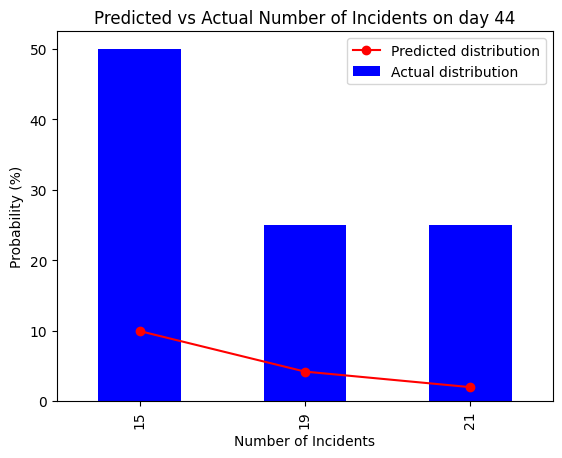

 62%|██████▏   | 44/71 [00:08<00:05,  5.27it/s]

Day 44 is not Poisson distributed with p-value 0.00039984291297178354


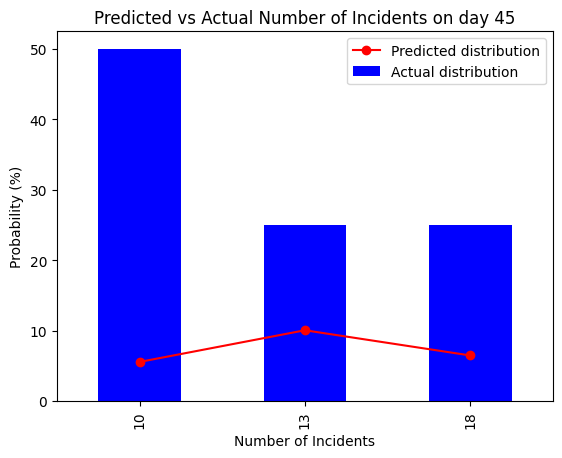

 63%|██████▎   | 45/71 [00:09<00:04,  5.24it/s]

Day 45 is not Poisson distributed with p-value 3.270504875559352e-08


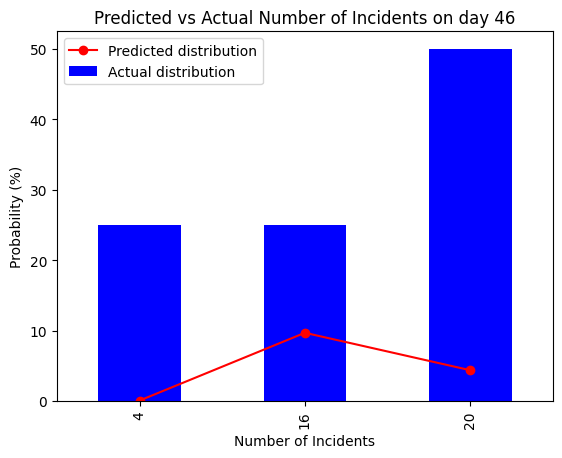

 65%|██████▍   | 46/71 [00:09<00:04,  5.53it/s]

Day 46 is not Poisson distributed with p-value 0.0


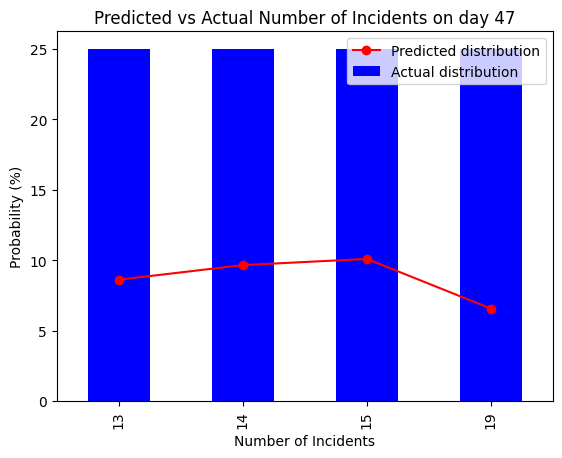

 66%|██████▌   | 47/71 [00:09<00:04,  5.43it/s]

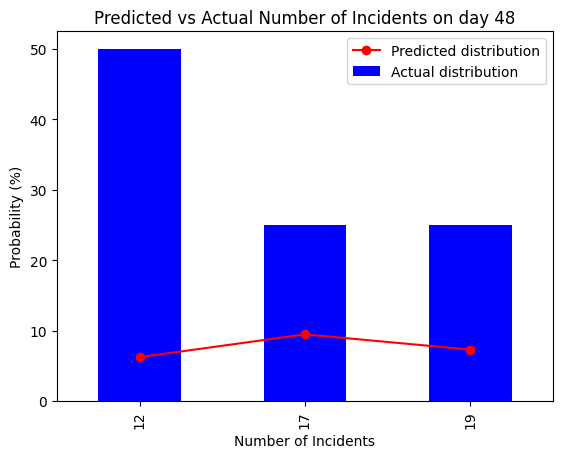

 68%|██████▊   | 48/71 [00:09<00:04,  5.65it/s]

Day 48 is not Poisson distributed with p-value 1.2314113578383953e-06


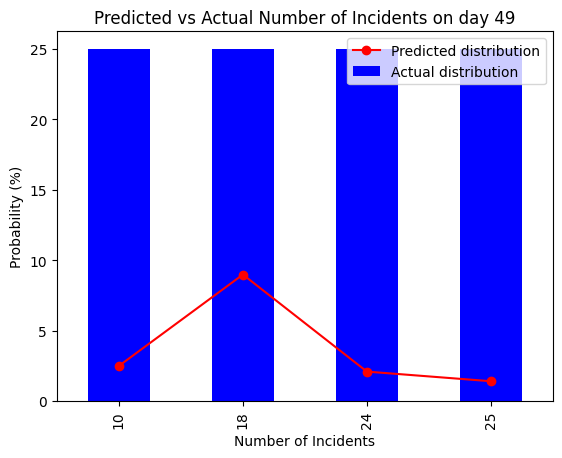

 69%|██████▉   | 49/71 [00:09<00:03,  5.87it/s]

Day 49 is not Poisson distributed with p-value 7.780755205627389e-13


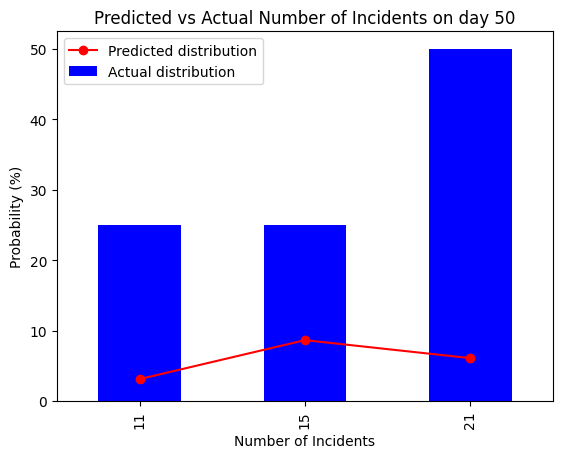

 70%|███████   | 50/71 [00:09<00:03,  5.97it/s]

Day 50 is not Poisson distributed with p-value 1.6402580271179346e-05


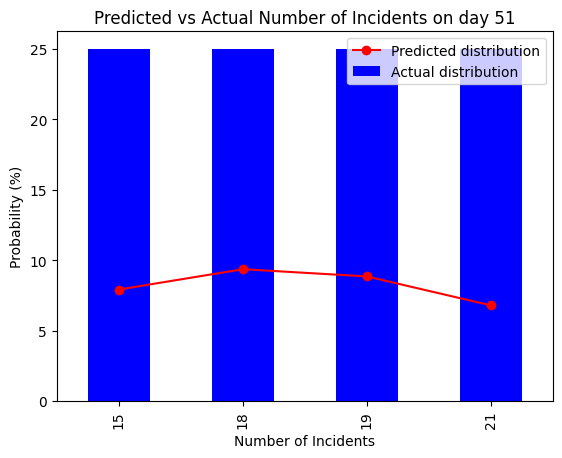

 72%|███████▏  | 51/71 [00:10<00:03,  5.02it/s]

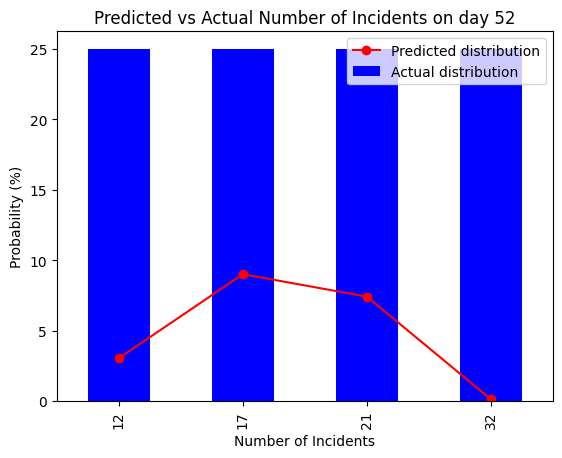

 73%|███████▎  | 52/71 [00:10<00:03,  5.26it/s]

Day 52 is not Poisson distributed with p-value 2.023007747382786e-200


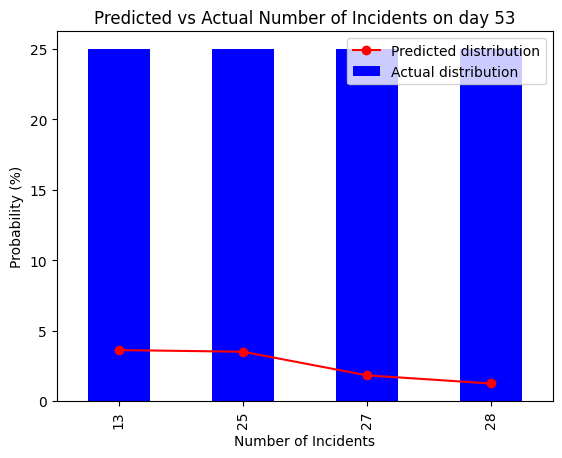

 75%|███████▍  | 53/71 [00:10<00:03,  5.46it/s]

Day 53 is not Poisson distributed with p-value 7.439777593822708e-05


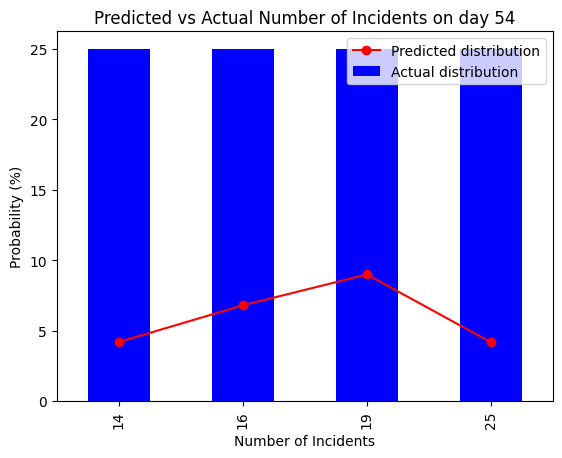

 76%|███████▌  | 54/71 [00:10<00:03,  5.45it/s]

Day 54 is not Poisson distributed with p-value 0.010606878677765764


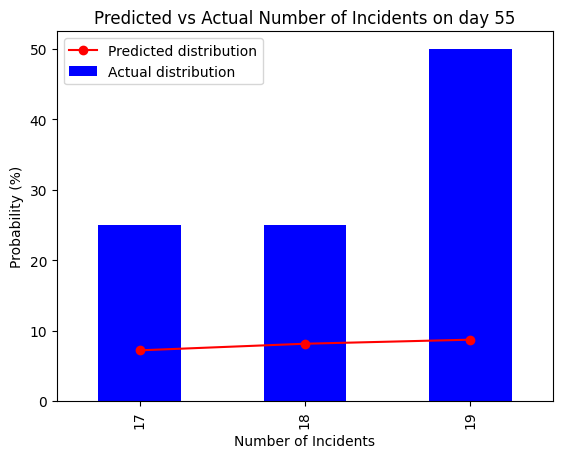

 77%|███████▋  | 55/71 [00:10<00:02,  5.34it/s]

Day 55 is not Poisson distributed with p-value 0.015372227837474951


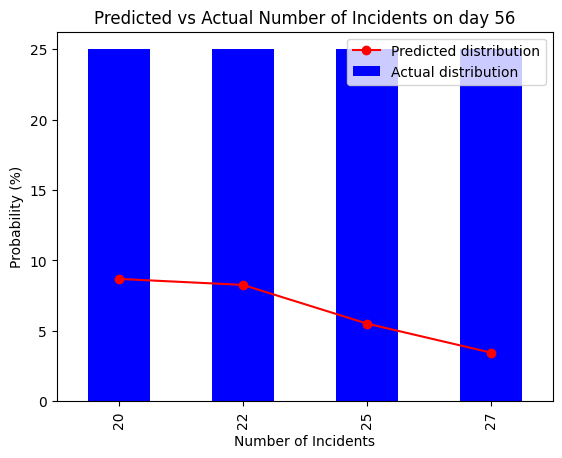

 79%|███████▉  | 56/71 [00:11<00:02,  5.30it/s]

Day 56 is not Poisson distributed with p-value 0.0022618985960887045


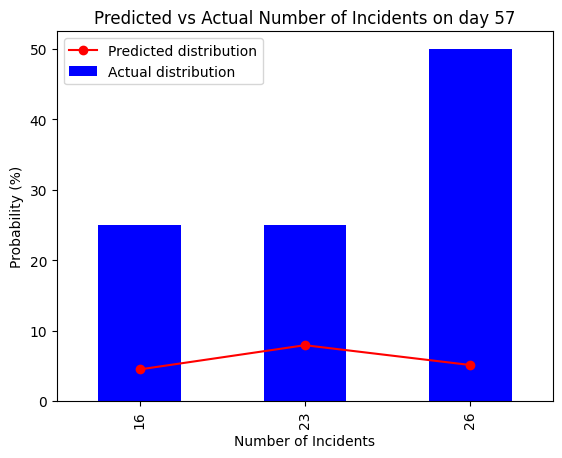

 80%|████████  | 57/71 [00:11<00:02,  5.64it/s]

Day 57 is not Poisson distributed with p-value 6.329072204590596e-06


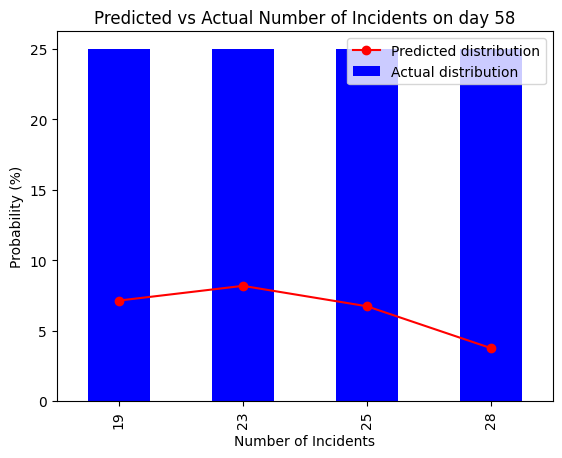

 82%|████████▏ | 58/71 [00:11<00:02,  5.58it/s]

Day 58 is not Poisson distributed with p-value 0.026558245634734183


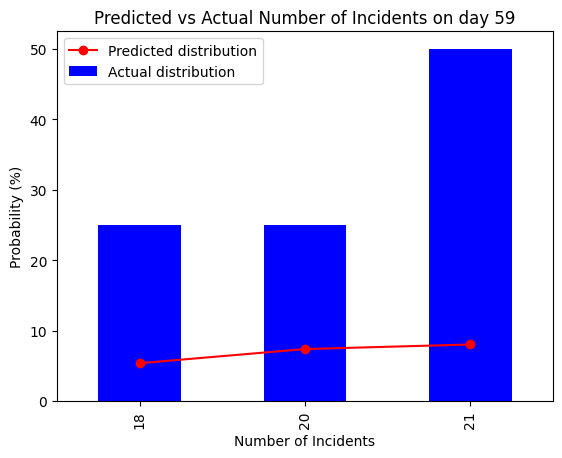

 83%|████████▎ | 59/71 [00:11<00:02,  5.70it/s]

Day 59 is not Poisson distributed with p-value 0.039334578276185105


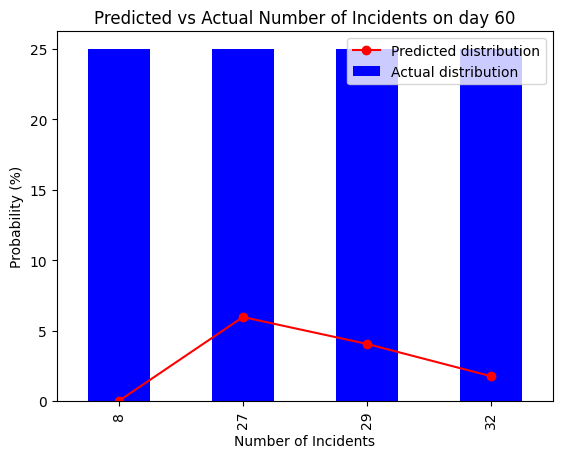

 85%|████████▍ | 60/71 [00:11<00:01,  5.81it/s]

Day 60 is not Poisson distributed with p-value 0.0


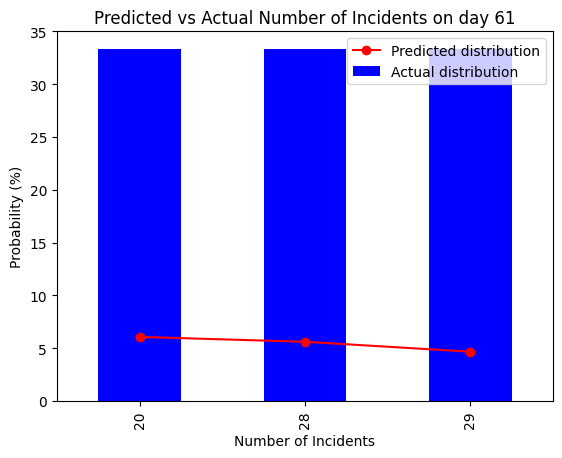

 86%|████████▌ | 61/71 [00:11<00:01,  5.67it/s]

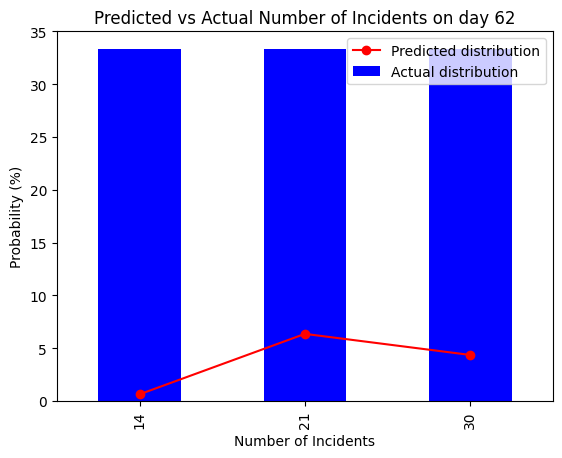

 87%|████████▋ | 62/71 [00:12<00:01,  5.86it/s]

Day 62 is not Poisson distributed with p-value 3.189033131871004e-32


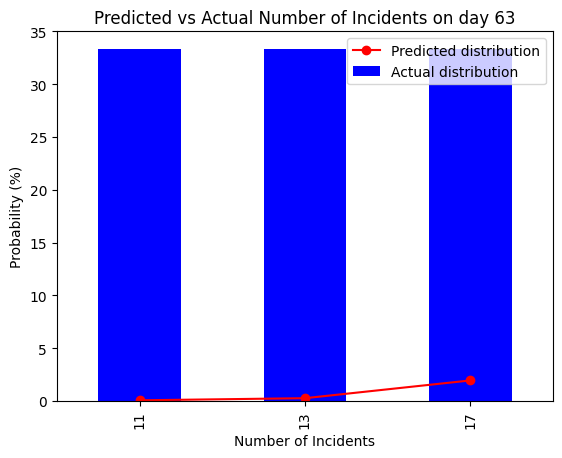

 89%|████████▊ | 63/71 [00:12<00:01,  5.87it/s]

Day 63 is not Poisson distributed with p-value 3.7922760723174e-89


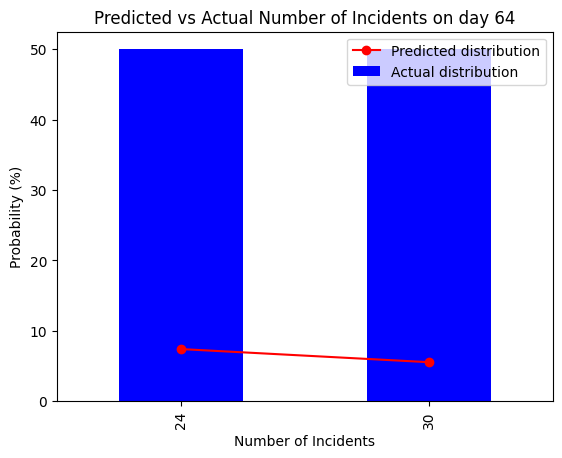

 90%|█████████ | 64/71 [00:12<00:01,  5.74it/s]

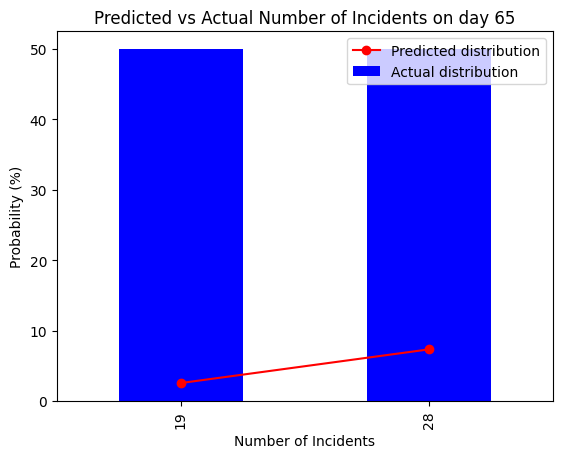

 92%|█████████▏| 65/71 [00:12<00:00,  6.02it/s]

Day 65 is not Poisson distributed with p-value 3.168872529134794e-08


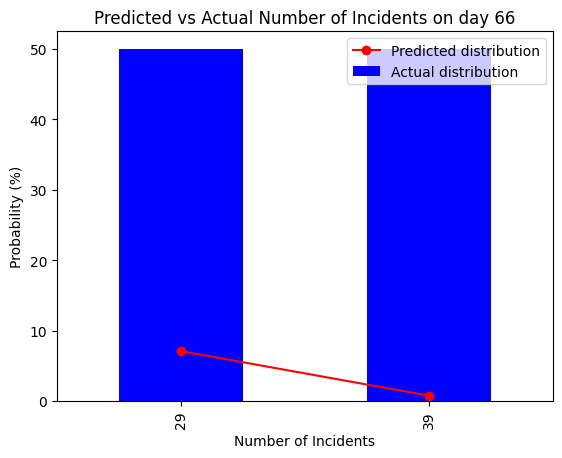

 93%|█████████▎| 66/71 [00:12<00:00,  6.19it/s]

Day 66 is not Poisson distributed with p-value 5.75997826358438e-42


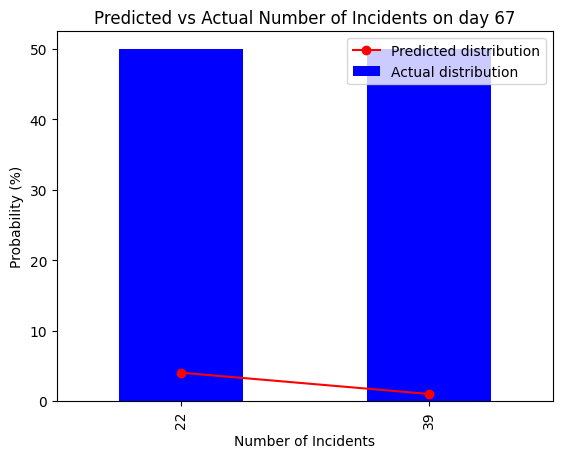

 94%|█████████▍| 67/71 [00:12<00:00,  6.09it/s]

Day 67 is not Poisson distributed with p-value 7.075854226265165e-14


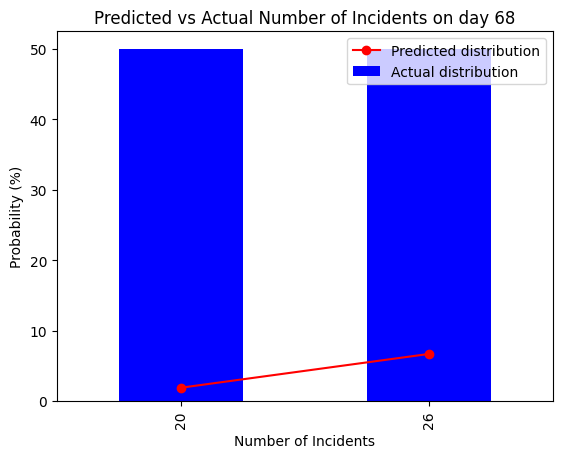

 96%|█████████▌| 68/71 [00:13<00:00,  5.84it/s]

Day 68 is not Poisson distributed with p-value 1.7632948803191968e-11


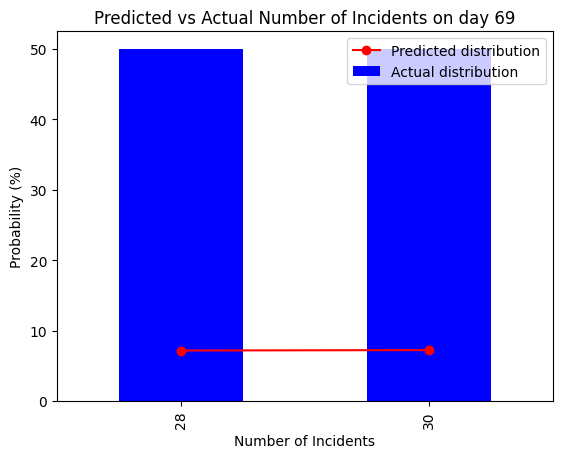

 97%|█████████▋| 69/71 [00:13<00:00,  6.02it/s]

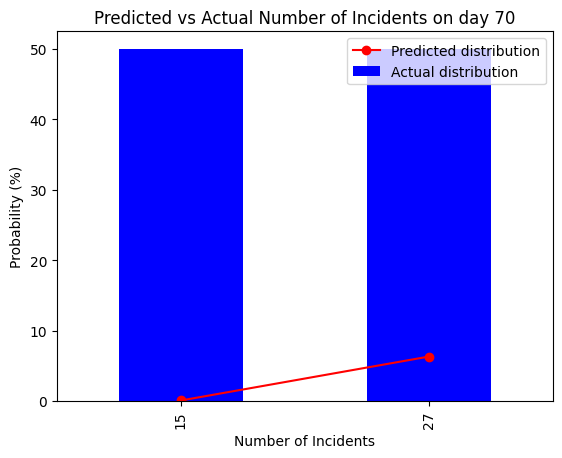

 99%|█████████▊| 70/71 [00:13<00:00,  6.22it/s]

Day 70 is not Poisson distributed with p-value 0.0


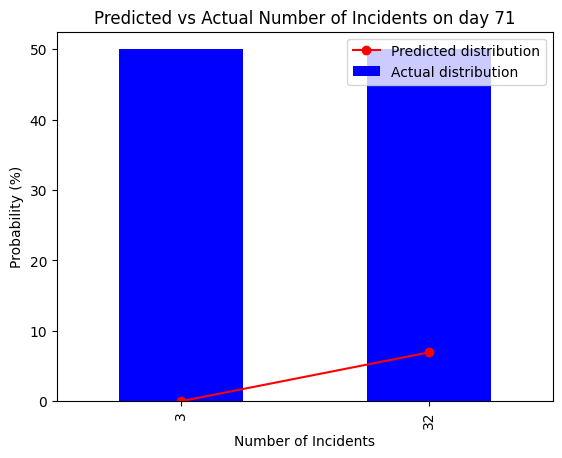

100%|██████████| 71/71 [00:13<00:00,  5.21it/s]

Day 71 is not Poisson distributed with p-value 0.0


In [317]:
for day in tqdm(range(1, incidents.j.max() + 1)):
    day_incidents = logs[logs['Day'] == day].groupby("Ship").sum()["metal_plate"]
    actual_data = day_incidents.value_counts(normalize=True) * 100
    actual_data = actual_data.sort_index() #sort by index to match the predicted data
    expected_data = stats.poisson.pmf(actual_data.index, f_j[day - 1] * 8) * 100 

    actual_data.plot(kind='bar', color='blue')
    plt.plot(expected_data, color='red', marker='o')
    plt.title(f"Predicted vs Actual Number of Incidents on day {day}")
    plt.xlabel("Number of Incidents")
    plt.ylabel("Probability (%)")
    plt.legend(['Predicted distribution', 'Actual distribution'])
    plt.show()
    
    test = hacked_chisquare(actual_data, expected_data)

    if test.pvalue < 0.05:
        print(f"Day {day} is not Poisson distributed with p-value {test.pvalue}")

We can see that the p-value is lower than 0.05 for most of days. So we would have to reject $H_0$.

However we can note that the test passes for $j \in [3, 10]$. so we can conclude that the model is adequat at least for those days.

For the first two days, I think the test fails because the stastic power of the test is very high so you need a very precise value of $\lambda_j$ to pass the test. 

And for the last days, I think the test fails because the number of ships is too low to have a good estimation of $\lambda_j$. Indeed from j > 16 we have less than 30 ships in the sample.

We can see on the graphs than the model seems kind of accurate for j < 16. For j > 16, we clearly see that the expected data is just too low to infer something.

## Conclusion

We can conclude that the number of incidents in a ship follows a Poisson law with parameter $\lambda_j$ which is a power function of the day, which is a good approximation of the real law for our needs.